In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

Using TensorFlow backend

In [3]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [4]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)


In [5]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [6]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [7]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [8]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: D)')

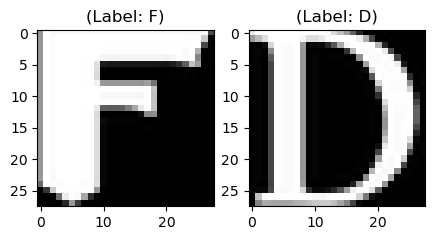

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [10]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [11]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [12]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [13]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [14]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [15]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [16]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [17]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [18]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [19]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856 

In [20]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/50
375/375 [==============================] - 188s 496ms/step - loss: 0.0433 - val_loss: 0.0179
Epoch 2/50
375/375 [==============================] - 142s 379ms/step - loss: 0.0152 - val_loss: 0.0122
Epoch 3/50
375/375 [==============================] - 141s 377ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 4/50
375/375 [==============================] - 142s 378ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 5/50
375/375 [==============================] - 152s 405ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 6/50
375/375 [==============================] - 157s 420ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 7/50
375/375 [==============================] - 155s 414ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 8/50
375/375 [==============================] - 183s 487ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 9/50
375/375 [==============================] - 158s 423ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 10/50
375/375 [==============================] - 198s 527m

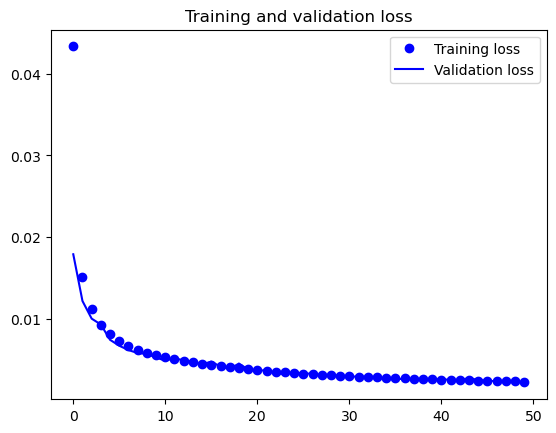

In [21]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
pred = autoencoder.predict(test_data)

313/313 [==============================] - 7s 23ms/step


In [23]:
pred.shape

(10000, 28, 28, 1)

Test Images


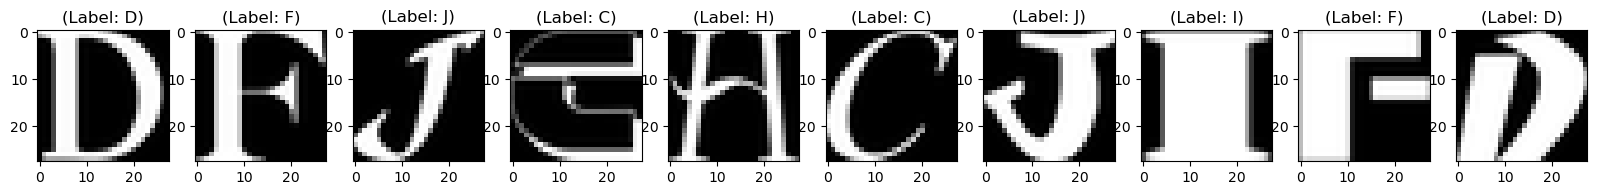

Reconstruction of Test Images


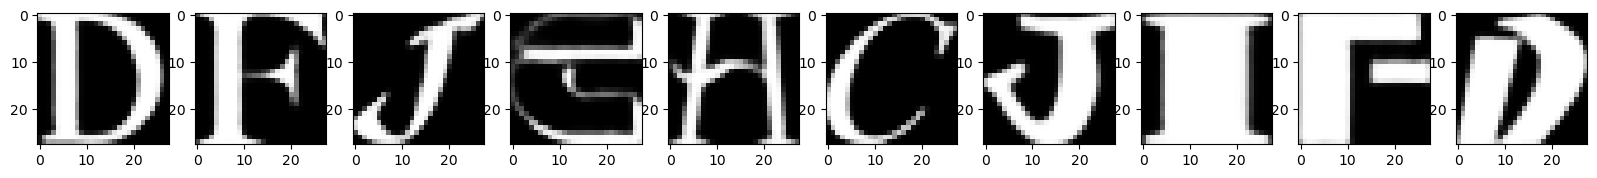

In [24]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

Denoising 

In [25]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

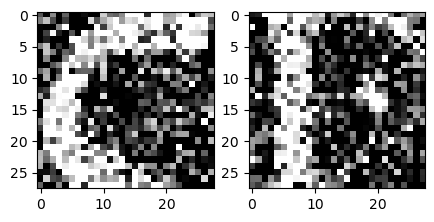

In [26]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [27]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [28]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [29]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [30]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

Epoch 1/20
375/375 [==============================] - 116s 308ms/step - loss: 0.0607 - val_loss: 0.0366
Epoch 2/20
375/375 [==============================] - 114s 305ms/step - loss: 0.0300 - val_loss: 0.0249
Epoch 3/20
375/375 [==============================] - 118s 315ms/step - loss: 0.0254 - val_loss: 0.0243
Epoch 4/20
375/375 [==============================] - 116s 309ms/step - loss: 0.0232 - val_loss: 0.0232
Epoch 5/20
375/375 [==============================] - 116s 308ms/step - loss: 0.0218 - val_loss: 0.0214
Epoch 6/20
375/375 [==============================] - 117s 312ms/step - loss: 0.0209 - val_loss: 0.0198
Epoch 7/20
375/375 [==============================] - 115s 308ms/step - loss: 0.0201 - val_loss: 0.0193
Epoch 8/20
375/375 [==============================] - 117s 312ms/step - loss: 0.0196 - val_loss: 0.0203
Epoch 9/20
375/375 [==============================] - 116s 311ms/step - loss: 0.0191 - val_loss: 0.0185
Epoch 10/20
375/375 [==============================] - 115s 307m

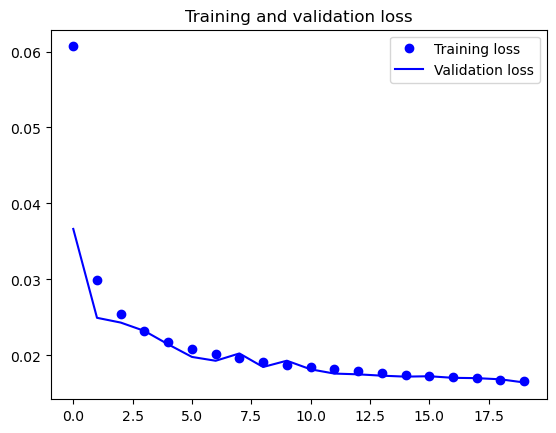

In [31]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [32]:
pred = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 7s 23ms/step


Test Images


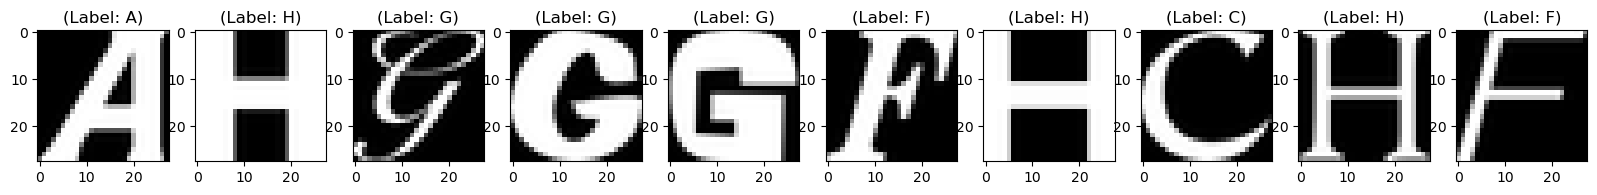

Test Images with Noise


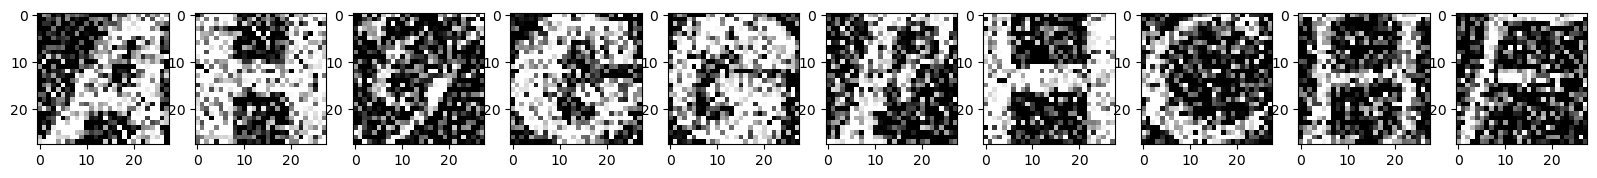

Reconstruction of Noisy Test Images


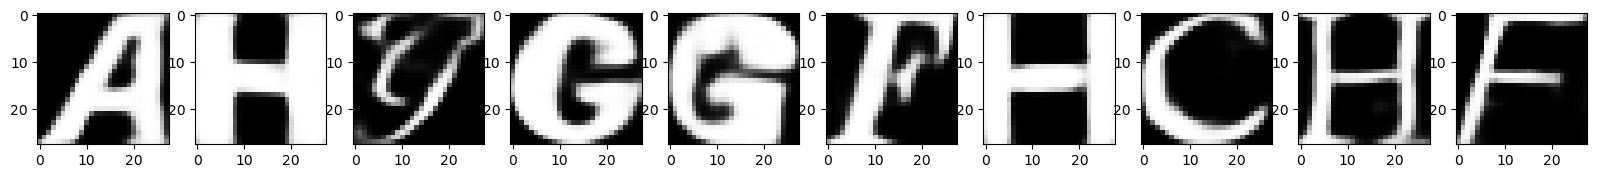

In [33]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()